# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

## 1. Autocorrelación Espacial.

En este ejercicio, analizaremos la distribución espacial de ciertos grupos demográficos  en la ciudad de Santiago, en base a los datos del Censo 2024 agrupados por zona censal.

En particular, analizaremos si hay autocorrelación espacial en la distribución de grupos demográficos como inmigrantes y pueblos originarios. Es decir, 
- ¿Cuál es el el nivel de similaridad entre el porcentaje de población  inmigrante en distintas zonas? 
- ¿Los valores en general siguen algún patrón espacial en cuanto a su distribución geográfica, o están distribuidos aleatoriamente en el espacio?



## 2. Importación de librerías

Para instalar PySAL, ver: https://pysal.org/install

- Installing PySAL via Conda

`conda install --channel conda-forge pysal`

- Install PySAL via pip

`pip install pysal`

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
from libpysal import weights
import esda 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


## 3. Datos.


Los datos para este ejercicio corresponden a un resumen de los datos del censo 2024 para la región Metropolitana, disponibles acá:https://censo2024.ine.gob.cl/resultados/

Puede descargar los datos para todo Chile, o por región. En este caso, se descargaron los datos de la Región Metropolitana en formato `geodatabase`, que comprende varias capas o layers, cada una asociadad a un distinto nivel de división cartográfica (región, provincia, zona, manzada, etc.)


In [2]:
#Datos en formato geodatabase
gdb_path='Cartografía_censo2024_R13.gdb/Cartografía_censo2024_R13.gdb'
layers = gpd.list_layers(gdb_path)
layers


,name,geometry_type
0,Zonal_CPV24,MultiPolygon
1,Provincial_CPV24,MultiPolygon
2,Regional_CPV24,MultiPolygon
3,Localidades_CPV24,MultiPolygon
4,Manzanas_CPV24,MultiPolygon
5,Entidades_CPV24,MultiPolygon
6,Limite_Urbano_CPV24,MultiPolygon
7,Comunal_CPV24,MultiPolygon
8,Distrital_CPV24,MultiPolygon
9,Aldeas_CPV24,MultiPolygon


In [3]:
#manz=gpd.read_file(gdb_path,layer='Manzanas_CPV24')
urb=gpd.read_file(gdb_path,layer='Limite_Urbano_CPV24')
#com=gpd.read_file(gdb_path,layer='Comunal_CPV24')
zonas=gpd.read_file(gdb_path,layer='Zonal_CPV24')

In [4]:
#Listado de todas las columnas de datos
for col in zonas.columns:
    print(col)

CUT
COD_REGION
REGION
COD_PROVINCIA
PROVINCIA
COMUNA
AREA_C
DISTRITO
COD_DISTRITO
COD_LOCALIDAD
COD_ZONA
LOCALIDAD
COD_ENTIDAD
ENTIDAD
COD_CATEGORIA
CATEGORIA
ID_ENTIDAD
ID_LOCALIDAD
ID_DISTRITO
ID_ZONA
n_per
n_hombres
n_mujeres
n_edad_0_5
n_edad_6_13
n_edad_14_17
n_edad_18_24
n_edad_25_44
n_edad_45_59
n_edad_60_mas
prom_edad
n_inmigrantes
n_nacionalidad
n_pueblos_orig
n_afrodescendencia
n_lengua_indigena
n_religion
n_dificultad_ver
n_dificultad_oir
n_dificultad_mover
n_dificultad_cogni
n_dificultad_cuidado
n_dificultad_comunic
n_discapacidad
n_estcivcon_casado
n_estcivcon_conviviente
n_estcivcon_conv_civil
n_estcivcon_anul_sep_div
n_estcivcon_viudo
n_estcivcon_soltero
prom_escolaridad18
n_asistencia_parv
n_asistencia_basica
n_asistencia_media
n_asistencia_superior
n_cine_nunca_curso_primera_infancia
n_cine_primaria
n_cine_secundaria
n_cine_terciaria_maestria_doctorado
n_cine_especial_diferencial
n_analfabet
n_ocupado
n_desocupado
n_fuera_fuerza_trabajo
n_cise_rec_independientes
n_cise

In [6]:
#Seleccionaremos algunas columnas de interés
cols=['CUT','COD_REGION','REGION','COD_PROVINCIA','PROVINCIA','COMUNA','COD_ZONA','ID_ZONA',
    'n_per','n_hombres','n_mujeres',
      'n_edad_0_5','n_edad_6_13','n_edad_14_17','n_edad_18_24','n_edad_25_44','n_edad_45_59','n_edad_60_mas','prom_edad',
      'n_inmigrantes','n_nacionalidad','n_pueblos_orig','n_desocupado','n_lengua_indigena','n_religion',
     'geometry']

zona=zonas[cols]

#El ID_ZONA es un número entero
zona['ID_ZONA']=zona['ID_ZONA'].astype('int')

/Users/paulaaguirre/anaconda3/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Acá elegimos la variable a analizar, y normalizamos por la población total de cada zona:


In [7]:
var='pueblos_orig'
zona['ratio_%s'%var]=zona['n_%s'%var]/zona['n_per']
field_correl='ratio_%s'%var
zona=zona[~zona[field_correl].isna()]

/Users/paulaaguirre/anaconda3/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


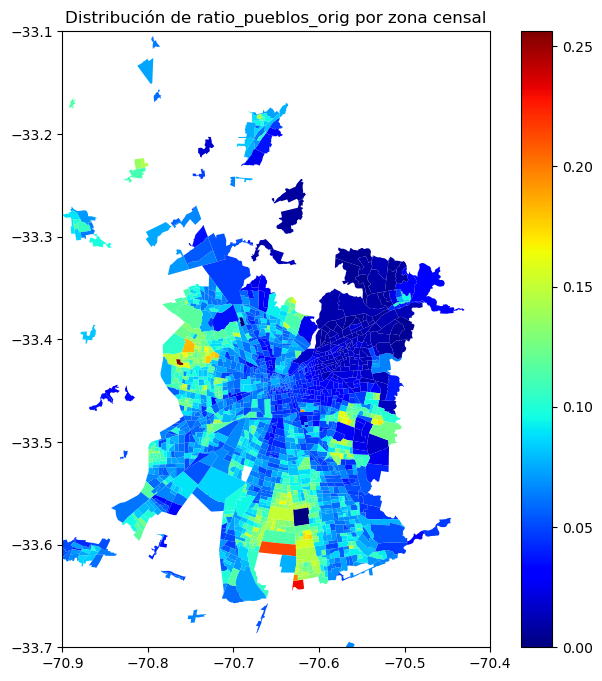

In [8]:
f, ax = plt.subplots(1, figsize=(8,8))

#graficaremos siempre en el CRS 4674 para mejor interpretabilidad de las coordenadas
zona.plot(ax=ax, column=field_correl,cmap='jet', linewidth=0.1,legend=True)

ax.set_title('Distribución de %s por zona censal'%field_correl.lower());
ax.set_xlim(-70.9,-70.4)
ax.set_ylim(-33.7,-33.1);

## 4. Matrices de pesos espaciales.

#### Como vimos en clases, hay distintas formas de definir una matriz de peso espacial

- Matrices de contiguidad: definen conexiones espaciales a partir la existencia de fronteras comunes. Ej: Queen y Rook.

- Matrices de distancia: asignan pesos a cada par de observaciones en base a la distancia dij entre los centroides de las unidades espaciales i, j. Hay distintas formas para convertir distancia en pesos, puede ser binario (ej: k-nearest neighbours) o continuo.

El cálculo de distintos tipos de matrices de pesos espaciales está implementado en la librería `weights`de PySAL:

https://pysal.org/libpysal/api.html



In [9]:
#Para cálculos de matrices basadas en distancia, es necesario usar un CRS proyectado.
zona=zona.to_crs(32719)

In [10]:
from libpysal import weights
print('Queen')
w_queen = weights.contiguity.Queen.from_dataframe(zona,idVariable='ID_ZONA')
print('Rook')
w_rook = weights.contiguity.Rook.from_dataframe(zona,idVariable='ID_ZONA')
print('KNN')
w_knn = weights.KNN.from_dataframe(zona,k=3,ids='ID_ZONA')
print('Distance')
w_dist_1km = weights.DistanceBand.from_dataframe(zona, 1000,ids='ID_ZONA')

Queen


/var/folders/vq/610jcp154qdbmww3xlq77dpw0000gp/T/ipykernel_71356/2980996485.py:3: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w_queen = weights.contiguity.Queen.from_dataframe(zona,idVariable='ID_ZONA')
/Users/paulaaguirre/anaconda3/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 67 disconnected components.
 There are 40 islands with ids: 1340206001, 1340205002, 1340205001, 1340402001, 1340407001, 1340405001, 1340407002, 1340404003, 1330101011, 1330101013, 1330106010, 1330105002, 1330103004, 1330201009, 1330201010, 1330302001, 1330302002, 1330302003, 1330302004, 1340112001, 1311913001, 1312407004, 1312407003, 1350116001, 1350112001, 1350110001, 1360305001, 1350103001, 1350108001, 1350109001, 1360302005, 1360402001, 1320303001, 1350201001, 1350203001, 1350307001, 1350401001, 1350402001, 1350403002, 1350402002.
  W.__init__(self, neighbors, ids=ids, **kw)

Rook
KNN
Distance


/Users/paulaaguirre/anaconda3/lib/python3.13/site-packages/libpysal/weights/contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 67 disconnected components.
 There are 40 islands with ids: 1340206001, 1340205002, 1340205001, 1340402001, 1340407001, 1340405001, 1340407002, 1340404003, 1330101011, 1330101013, 1330106010, 1330105002, 1330103004, 1330201009, 1330201010, 1330302001, 1330302002, 1330302003, 1330302004, 1340112001, 1311913001, 1312407004, 1312407003, 1350116001, 1350112001, 1350110001, 1360305001, 1350103001, 1350108001, 1350109001, 1360302005, 1360402001, 1320303001, 1350201001, 1350203001, 1350307001, 1350401001, 1350402001, 1350403002, 1350402002.
  W.__init__(self, neighbors, ids=ids, **kw)
/Users/paulaaguirre/anaconda3/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/Users/paul

Para explorar las propiedades de los objetos resultantes, hagamos foco en una zona cualquiera:`ID_ZONA=1311801003`

Queen ==> Cardinalities, neighbors, weights: 7 [1311802001, 1311804004, 1311805002, 1311806005, 1311801002, 1311801004, 1311805004] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Rook ==> Cardinalities, neighbors, weights: 5 [1311802001, 1311806005, 1311801002, 1311801004, 1311805004] [1.0, 1.0, 1.0, 1.0, 1.0]
KNN ==> Cardinalities, neighbors, weights: 3 [np.int64(1311802001), np.int64(1311801004), np.int64(1311801002)] [1.0, 1.0, 1.0]
Dist ==> Cardinalities, neighbors, weights: 7 [1311801001, 1311801002, 1311801004, 1311805004, 1311806005, 1311804004, 1311802001] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


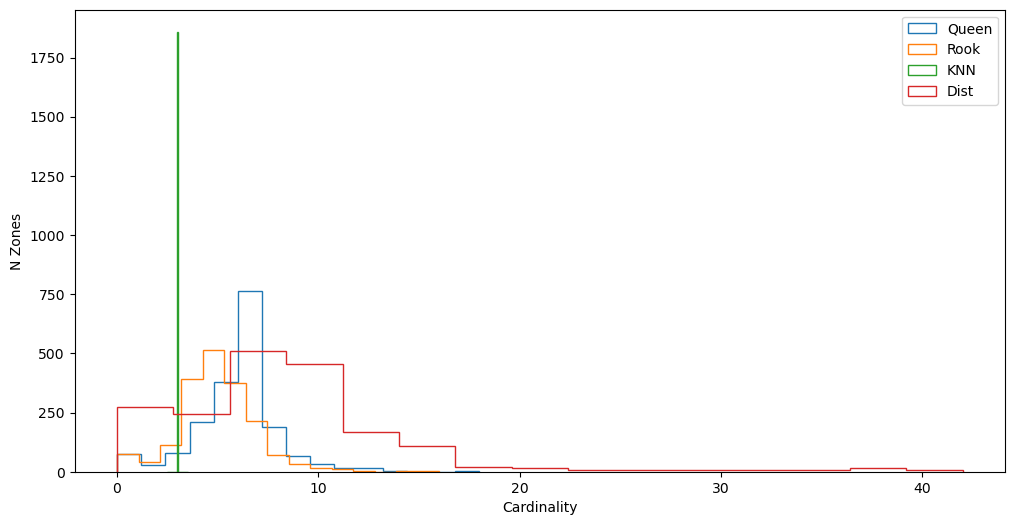

In [11]:
f, ax= plt.subplots(1,sharey=True)
f.set_size_inches(12,6)

W={'Queen':w_queen,'Rook':w_rook,'KNN':w_knn,'Dist':w_dist_1km}
ID_ZONA=1311801003

for kw in W.keys():
    w=W[kw]
    print(kw,'==> Cardinalities, neighbors, weights:',w.cardinalities[ID_ZONA],w.neighbors[ID_ZONA],w.weights[ID_ZONA])
    card=pd.Series(w.cardinalities)
    ax.hist(card, bins=15,histtype='step',label=kw)
    
ax.set_xlabel('Cardinality')
ax.set_ylabel('N Zones')
ax.legend();

### ¿Cómo se ven las distintas matrices para un determinada zona (`ID_ZONA=1311801003`)?

In [12]:
#identificamos los vecinos
neis_id= w[ID_ZONA].keys()
neis=zona[zona['ID_ZONA'].isin(neis_id)]

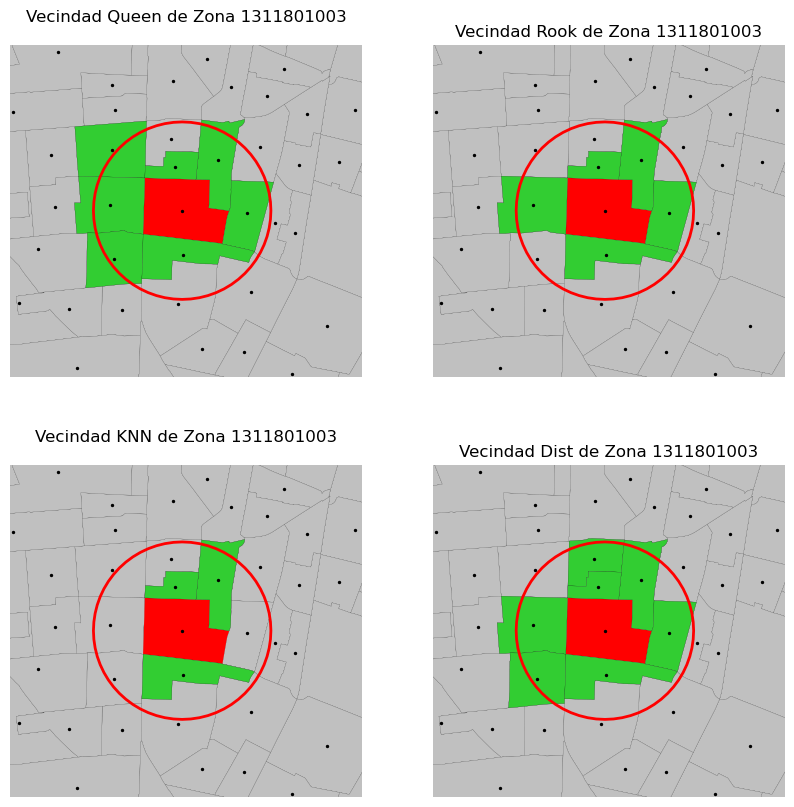

In [13]:
f,axes = plt.subplots(2,2,sharey=True)
f.set_size_inches(10,10)
axs=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]]

ID_ZONA=1311801003

focus=zona[zona['ID_ZONA']==ID_ZONA]
bounds=focus.bounds.values[0]

for ax in axs:
    zona.plot(ax=ax, facecolor='silver',edgecolor='k', linewidth=0.1)
    focus.plot(facecolor='red', alpha=1, linewidth=0, ax=ax)

    ax.set_xlim(bounds[0]-1500,bounds[2]+1500)
    ax.set_ylim(bounds[1]-1500,bounds[3]+1500)
    ax.axis('off')

for kw,ax in zip(W.keys(),axs):
    w=W[kw]
    ax.set_title("Vecindad %s de Zona %d"%(kw,ID_ZONA))
    
    #vecinos de la zona 100
    neis_id= w[ID_ZONA].keys()
    neis=zona[zona['ID_ZONA'].isin(neis_id)]
    neis.plot(ax=ax, facecolor='limegreen',edgecolor='k', linewidth=0.1)
    
    #buffer de 1000 m alrededor de la zona 100
    buf = focus.centroid.buffer(1000)
    buf.plot(edgecolor='red', facecolor='none', lw=2,ax=ax)
    zona.centroid.plot(ax=ax, color='k',markersize=2)
plt.show();

## 5. Lag espacial.

Es el producto de una matriz de peso espacial y la variable misma, donde $Y$ es un vector $Nx1$ con los valores de la variable:

$$ Y_{SL}=Y \cdot W $$

- En general es conveniente normalizar los pesos espaciales para remover efectos de escala (por ejemplo, unidades de distancia utilizadas). En general, se acostumbra normalizar la matriz $W$ fila: los pesos en cada fila son normalizados para sumar 1, de manera cada peso $w_{ij}$  puede ser interpretado como la fracción de toda la influencia espacial sobre $i$  atribuido a la unidad $j$.


- También es conveniente normalizar los valores de la variable antes de calcular su lag espacial, y reescalar de manera que su distribución tenga promedio 0 y desviación estándar 1.

$$ z_i=\frac{x_i-\bar{x}}{\sigma}$$


In [14]:
W={'Queen':w_queen,'Rook':w_rook,'KNN':w_knn,'Dist':w_dist_1km}

#para cada tipo de matriz
for kw in W.keys():
    
    # normalizacion por filas de la matriz W 
    w=W[kw]
    w.transform ='R'
    
    #normalizacion de la variable
    mean=zona[field_correl].mean()
    std=zona[field_correl].std()
    normed=(zona[field_correl]-mean)/std
    
    #agrego la variable normalizada como columna al data frame
    
    zona['%s_norm'%field_correl]=normed
    
    #calculo del lag espacial, se convierte a una serie y se agrega como columna adicional al data frame
    w_lag = weights.lag_spatial(w, normed)
    zona['slag_%s_%s'%(kw,field_correl)] = weights.lag_spatial(w, normed)
   
print(zona.columns)

('WARNING: ', 1340206001, ' is an island (no neighbors)')
('WARNING: ', 1340205002, ' is an island (no neighbors)')
('WARNING: ', 1340205001, ' is an island (no neighbors)')
('WARNING: ', 1340402001, ' is an island (no neighbors)')
('WARNING: ', 1340407001, ' is an island (no neighbors)')
('WARNING: ', 1340405001, ' is an island (no neighbors)')
('WARNING: ', 1340407002, ' is an island (no neighbors)')
('WARNING: ', 1340404003, ' is an island (no neighbors)')
('WARNING: ', 1330101011, ' is an island (no neighbors)')
('WARNING: ', 1330101013, ' is an island (no neighbors)')
('WARNING: ', 1330106010, ' is an island (no neighbors)')
('WARNING: ', 1330105002, ' is an island (no neighbors)')
('WARNING: ', 1330103004, ' is an island (no neighbors)')
('WARNING: ', 1330201009, ' is an island (no neighbors)')
('WARNING: ', 1330201010, ' is an island (no neighbors)')
('WARNING: ', 1330302001, ' is an island (no neighbors)')
('WARNING: ', 1330302002, ' is an island (no neighbors)')
('WARNING: ', 

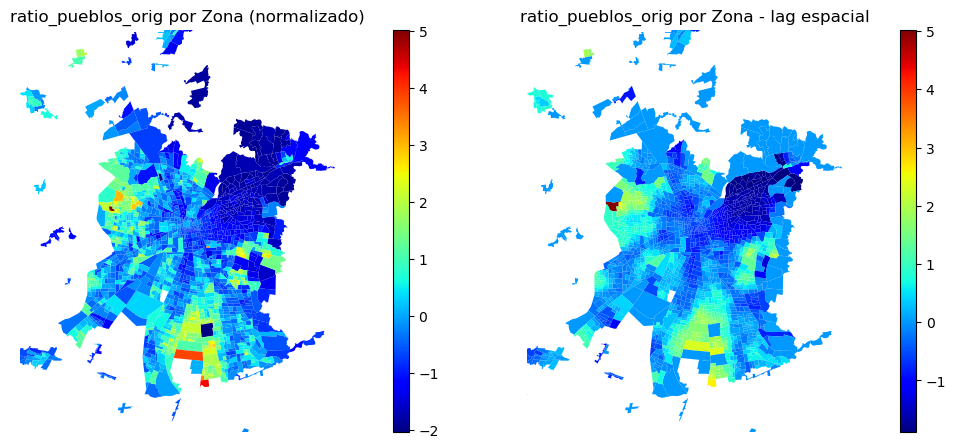

In [15]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

f, axes = plt.subplots(1,2, figsize=(12,12))

im=zona.to_crs(4674).plot(ax=axes[0], column='%s_norm'%field_correl,cmap='jet', linewidth=0.4,legend=False)
#zona.boundary.plot(ax=axes[0], color='black',linewidth=0.4,label='Zonas')
axes[0].set_title('%s por Zona (normalizado)'%field_correl)
ax_divider = make_axes_locatable(axes[0])
cax = ax_divider.append_axes("right", size="4%", pad="1%")
plt.colorbar(axes[0].collections[0],cax=cax);
axes[0].axis('off');
axes[0].set_xlim(-70.9,-70.4)
axes[0].set_ylim(-33.7,-33.2);


zona.to_crs(4674).plot(ax=axes[1], column='slag_Dist_%s'%field_correl,cmap='jet', linewidth=0.4,legend=False)
#zona.boundary.plot(ax=axes[1], color='black',linewidth=0.4,label='Zonas')
axes[1].set_title('%s por Zona - lag espacial'%field_correl)
ax_divider = make_axes_locatable(axes[1])
cax = ax_divider.append_axes("right", size="4%", pad="1%")
plt.colorbar(axes[1].collections[0],cax=cax)
axes[1].set_xlim(-70.9,-70.4)
axes[1].set_ylim(-33.7,-33.2);
axes[1].axis('off');

## 6. Gráfico de Moran.

- Es una herramienta gráfica para explorar el concepto de autocorrelación espacial a nivel global.

- Consiste en un scatter plot en el cual una variable dada es graficada versus su propio lag espacial (valor promedio en el vecindario).

- El gráfico de Moran se puede resumir en una estadística global de autocorrelación espacial: el índice $I$ de Moran, calculado como la pendiente del fit lineal al gráfico de Moran.

La librería `esda`de PySAL provee herramietnas para calcular la estadística de Moran: https://pysal.org/esda/api.html




In [16]:
#Por ejemplo, para una matriz tipo Rook
w=W['Rook']
w.transform = "R"

moran = esda.moran.Moran(zona['%s_norm'%field_correl], w)
moran.I

np.float64(0.7504418915681936)

Queen Slope: 0.7308345942463411
Rook Slope: 0.7342946749664038
KNN Slope: 0.7650217056329505
Dist Slope: 0.6840941043917127


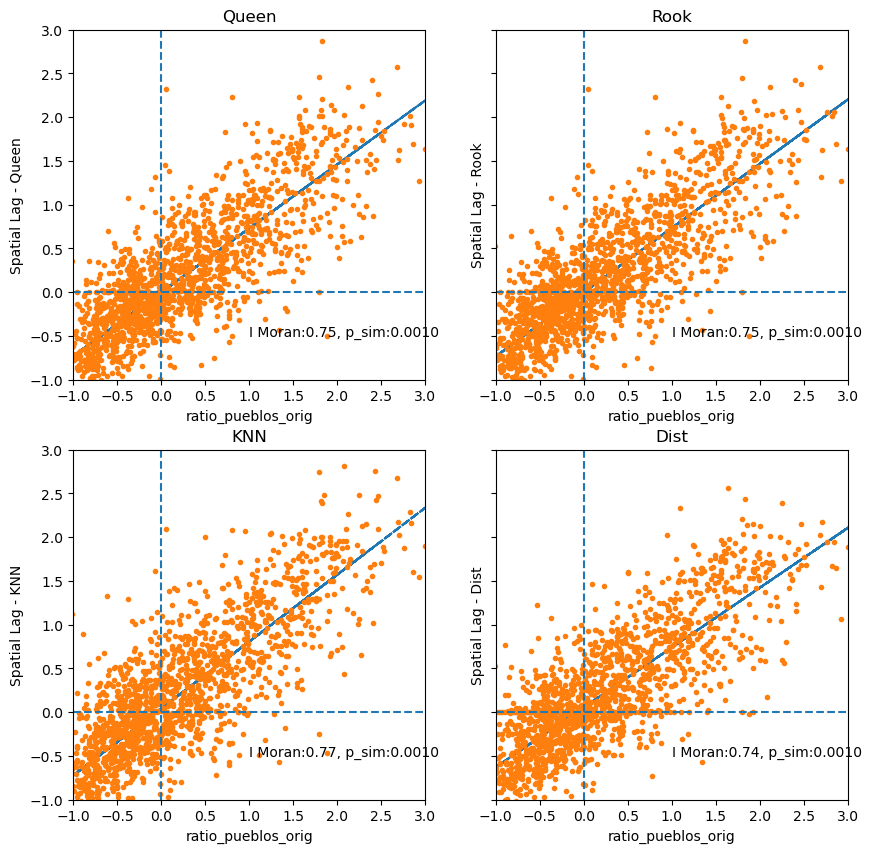

In [17]:
f,axes = plt.subplots(2,2,sharey=True)
f.set_size_inches(10,10)
axs=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]]

for kw,ax in zip(W.keys(),axs):
    w=W[kw]
    x=zona['%s_norm'%field_correl]
    y=zona['slag_%s_%s'%(kw,field_correl)]
    
    try:
        m,b= np.polyfit(x, y, 1)
        print(kw,'Slope:',m)
        ax.plot(x,m*x+b,ls='--')
    except:
        print(kw,' no fit')
    
    ax.plot(x,y,'.')
    #ax.plot(x,m*x+b,ls='--')
    ax.set_xlabel(field_correl)
    ax.set_ylabel('Spatial Lag - %s' %kw)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(kw)
    ax.axhline(y=0,ls='--')
    ax.axvline(x=0,ls='--')

    
    mi = esda.moran.Moran(x, w)
    ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim))


## 7. Significancia de la autocorrelación espacial.

Un resultado es estadísticamente significativo si permite rechazar la hipótesis nula de aleatoreidad espacial.

Es decir, ¿la distribución de valores sobre(bajo) la media, es distinto a los que esperaríamos si el proceso fuera totalmente aleatorio?

Una forma de verificar el nivel de significancia de $I$ es mediante permutaciones espaciales aleatorias:  se calcula una distribución de referencia haciendo una (en verdad, muchas, ~1000) permutación aleatoria de los valores observados entre todas las ubicaciones.
Luego se calcula la estadística para todas las permutaciones y se obtiene una distribución de referencia.
Esta distribución se usa para cacular el valor $p$, de acuerdo a:

Donde:
- M: número de permutaciones
- R: número de veces que el $I$ calculado para los datasets aleatorios es igual o mayor que el observado.

## 8. Indicadores locales de autocorrelación espacial (LISA).

El índice de Moran indica el nivel de autocorrelación global del conjunto de datos.
En general, ¿hay un patrón espacial en los datos, o se trata de una distribución espacialmente aleatoria?

Si es que hay un patrón espacial, ¿cuáles son las unidades espaciales que están correlacionadas (positiva o negativamente) con sus vecinos? ¿dónde están los clusters? ¿qué áreas contribuyen más (o menos) a nuestra estadística global?

Para ello, utilizamos los indicadores de autocorrelación local (LISA).


In [18]:
#ejemplo para una matriz, tipo Rook
w=W['Rook']
x=zona['%s_norm'%field_correl]
y=zona['slag_%s_%s'%(kw,field_correl)]

lisa = esda.moran.Moran_Local(x, w)
lisa

/Users/paulaaguirre/anaconda3/lib/python3.13/site-packages/esda/moran.py:1351: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


In [19]:
lisa.p_sim

array([0.001, 0.434, 0.001, ..., 0.112, 0.351, 0.169], shape=(1859,))

In [20]:
lisa.q

array([3, 2, 4, ..., 3, 4, 3], shape=(1859,))

Slope: 0.6840941043917127


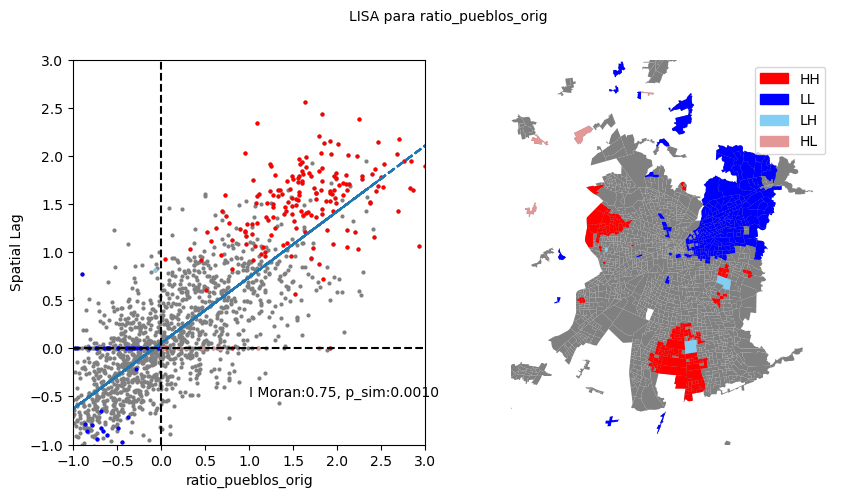

In [23]:
import matplotlib.patches as mpatches

zona['quadrant'] = lisa.q
zona['significant'] = lisa.p_sim < 0.01

quads={1:'HH',2:'LH',3:'LL',4:'HL'}

palette = {'LL': 'blue','HH':'red','LH':'#83cef4','HL':'#e59696'}
               
zona['quad_class'] = [quads[x] for x in zona['quadrant']]

HHm=(zona['significant']) & (zona['quadrant']==1) 
LLm=(zona['significant']) & (zona['quadrant']==3) 
HLm=(zona['significant']) & (zona['quadrant']==4) 
LHm=(zona['significant']) & (zona['quadrant']==2) 

f,(ax,ax2) = plt.subplots(1,2, figsize=(10,5))

#Moran
m,b= np.polyfit(x, y, 1)
print('Slope:',m)
ax.plot(x,y,'o',color='gray',markersize=2)

ax.plot(x[HHm],y[HHm],'o',color='r',markersize=2)
ax.plot(x[LLm],y[LLm],'o',color='b',markersize=2)
ax.plot(x[LHm],y[LHm],'o',color='#83cef4',markersize=2)
ax.plot(x[HLm],y[HLm],'o',color='#e59696',markersize=2)

ax.plot(x,m*x+b,ls='--')
ax.set_xlabel(field_correl,fontsize=10)
ax.set_ylabel('Spatial Lag' ,fontsize=10)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

    
mi = esda.moran.Moran(x, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=10)

#mapa
sig=zona[zona['significant']]
zona.to_crs(4674).plot(color='gray',ax=ax2)

#datsig={'HH':HH[HHm],'LL':LL[LLm],'LH':LH[LHm],'HL':HL[HLm]}
datsig={'HH':HHm,'LL':LLm,'LH':LHm,'HL':HLm}

handles=[]
for ctype in datsig.keys():
    data=zona[datsig[ctype]].to_crs(4674)
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=10)
ax2.set_xlim(-70.9,-70.4)
ax2.set_ylim(-33.7,-33.2);

ax2.set_axis_off()
f.suptitle('LISA para %s'%field_correl, size=10);


